In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import clear_output
import time

### Graph Environment Implementation

- Constructs the graph with edges: 0-4, 2-3, 3-1, 3-4, 1-5, 4-5, 5-5
- Provides methods for resetting, taking steps, and visualization

In [33]:
class GraphEnvironment:
    def __init__(self):
        # Our graph with 6 vertices (0,1,2,3,4,5) and edges:
        # 0-4, 2-3, 3-1, 3-4, 1-5, 4-5, 5-5
        self.graph = {
            0: [4],         # Vertex 0 is connected to vertex 4
            1: [3, 5],      # Vertex 1 is connected to vertices 3 and 5
            2: [3],         # Vertex 2 is connected to vertex 3
            3: [1, 2, 4],   # Vertex 3 is connected to vertices 1, 2, and 4
            4: [0, 3, 5],   # Vertex 4 is connected to vertices 0, 3, and 5
            5: [1, 4, 5]    # Vertex 5 is connected to vertices 1, 4, and itself (self-loop)
        }
        
        # Our goal is to reach vertex 5
        self.goal_state = 5
        
        # Current position (will be set when we reset the environment)
        self.current_state = None
        
    def reset(self, start_state=None):
        """Reset the environment to a starting state"""
        if start_state is not None and start_state in self.graph:
            # If a specific start state is given, use it
            self.current_state = start_state
        else:
            # Otherwise, randomly choose any vertex except the goal
            self.current_state = np.random.choice([0, 1, 2, 3, 4])
        
        return self.current_state
        
    def step(self, action):
        """Take an action (move to a neighbor) and return new state, reward, done"""
        # In our graph, an action is choosing which neighbor to move to
        # The action is an index into the list of neighbors
        
        # Check if action is valid (within the range of available neighbors)
        if action < len(self.graph[self.current_state]):
            # Get the next state (the neighbor we're moving to)
            next_state = self.graph[self.current_state][action]
            
            # Update our current position
            self.current_state = next_state
            
            # Check if we've reached the goal
            done = (self.current_state == self.goal_state)
            
            # Define reward:
            # +1 if we reached the goal
            # -0.01 small penalty for each step (to encourage finding shortest path)
            if done:
                reward = 100  
            else:
                reward = 0
                
            return self.current_state, reward, done
        else:
            # Invalid action - return current state with a penalty
            return self.current_state, 0, False
    
    def get_valid_actions(self, state):
        """Return the number of valid actions for a given state"""
        return len(self.graph[state])
    
    def render(self):
        """Visualize the graph and current position"""
        # Create a networkx graph
        G = nx.Graph()
        
        # Add all edges from our graph
        for node, neighbors in self.graph.items():
            for neighbor in neighbors:
                G.add_edge(node, neighbor)
        
        # Set up the visualization
        pos = nx.spring_layout(G, seed=42)  # Layout with consistent positions
        plt.figure(figsize=(8, 6))
        
        # Color nodes: 
        # - Red for current position
        # - Green for goal
        # - Gold if current position is the goal
        # - Blue for all others
        node_colors = []
        for node in G.nodes():
            if node == self.current_state and node == self.goal_state:
                node_colors.append('gold')
            elif node == self.current_state:
                node_colors.append('red')
            elif node == self.goal_state:
                node_colors.append('green')
            else:
                node_colors.append('lightblue')
        
        # Draw the graph
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
        nx.draw_networkx_edges(G, pos, width=2)
        nx.draw_networkx_labels(G, pos, font_size=15)
        
        plt.title(f"Current State: {self.current_state}, Goal: {self.goal_state}")
        plt.axis('off')
        plt.show()


In [41]:
# Create the environment
env = GraphEnvironment()

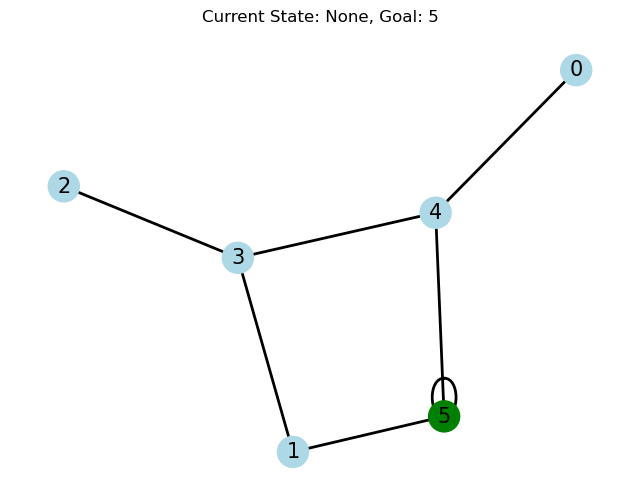

In [42]:
env.render()

In [43]:
env.get_valid_actions(1), env.get_valid_actions(2), env.get_valid_actions(5)

(2, 1, 3)

In [44]:
env.current_state, env.goal_state

(None, 5)

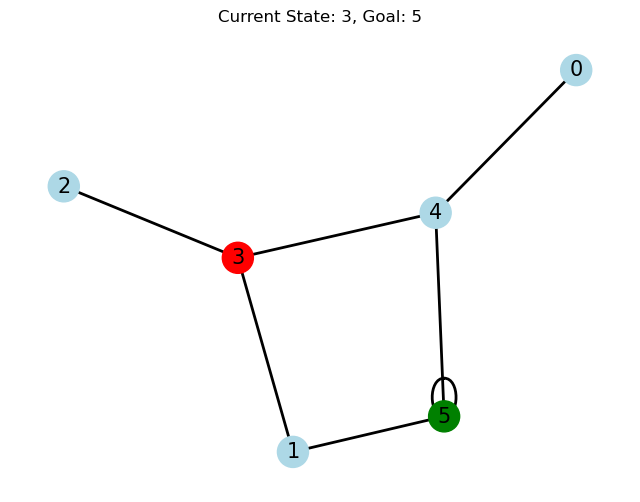

In [45]:
env.reset(start_state=3)
env.render()

In [46]:
current_state, reward, get_gole = env.step(0)
print("We do the step from 3 to 1, the current state is: ", current_state)
print("The reward we get from this action: ", reward)
print("Did we achieve the goal: ", get_gole)

We do the step from 1 to 3, the current state is:  1
The reward we get from this action:  0
Did we achieve the goal:  False


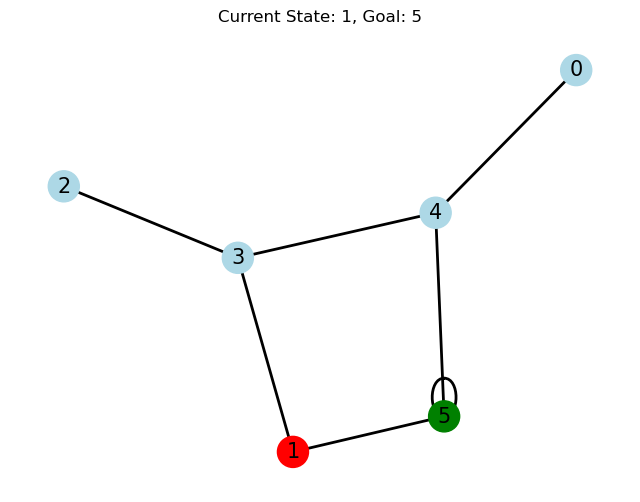

In [47]:
env.render()

### Q-Learning Agent:

- Implements an epsilon-greedy policy for exploration vs. exploitation
- Maintains a Q-table to store state-action values
- Learns through trial and error with a reward structure

In [54]:
class SimpleQLearningAgent:
    def __init__(self, n_states=6, max_actions=3, 
                 learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0):
        """
        Initialize a simple Q-learning agent
        
        Parameters:
        - n_states: number of vertices in the graph
        - max_actions: maximum number of neighbors any vertex has
        - learning_rate: how quickly the agent learns (alpha)
        - discount_factor: how much future rewards matter (gamma)
        - exploration_rate: how often to explore vs exploit (epsilon)
        """
        # Initialize Q-table with zeros
        # Q-table shape: [state, action] -> expected future reward
        self.q_table = np.zeros((n_states, max_actions))
        
        # Set learning parameters
        self.learning_rate = learning_rate  
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        
    def choose_action(self, state, valid_actions):
        """Select an action using epsilon-greedy policy"""
        # Epsilon-greedy: sometimes explore, sometimes exploit
        
        if np.random.random() < self.exploration_rate:
            # EXPLORE: choose a random valid action
            return np.random.randint(0, valid_actions)
        else:
            # EXPLOIT: choose the best action according to Q-table
            # Only consider valid actions for this state
            state_q_values = self.q_table[state, :valid_actions]
            return np.argmax(state_q_values)
    
    def learn(self, state, action, reward, next_state, next_valid_actions, done):
        """Update Q-table based on the observed transition"""
        # Q-Learning formula: Q(s,a) = Q(s,a) + α * [r + γ * max(Q(s',a')) - Q(s,a)]
        
        # First, find the best expected future reward from the next state
        next_q_values = self.q_table[next_state, :next_valid_actions]
        best_next_q = np.max(next_q_values) if next_valid_actions > 0 else 0
        
        # If we're done (reached the goal), there's no future reward
        if done:
            future_reward = 0
        else:
            future_reward = self.discount_factor * best_next_q
        
        # Calculate the target Q-value
        target_q = reward + future_reward
        
        # Update the Q-value for the current state and action
        current_q = self.q_table[state, action]
        self.q_table[state, action] = current_q + self.learning_rate * (target_q - current_q)
    
    def decrease_exploration(self, decay=0.995):
        """Gradually reduce exploration rate to exploit more over time"""
        self.exploration_rate *= decay
        # Don't let it go below 0.01 (1% exploration)
        self.exploration_rate = max(0.01, self.exploration_rate)

### Training Process:

- Trains the agent over 300 episodes
- Tracks metrics like reward, episode length, and success rate

In [55]:
def train_agent(episodes=300, render_every=50):
    """Train the agent on the graph environment"""
    
    # Create environment and agent
    env = GraphEnvironment()
    
    # Find max number of actions in any state (maximum neighbors)
    max_actions = max(len(neighbors) for neighbors in env.graph.values())
    
    # Create our agent
    agent = SimpleQLearningAgent(
        n_states=6,                 # 6 vertices in our graph
        max_actions=max_actions,    # Maximum number of neighbors
        learning_rate=0.1,          # Learn at a moderate pace
        discount_factor=0.95,       # Care a lot about future rewards
        exploration_rate=1.0        # Start fully exploring
    )
    
    # Lists to track training progress
    all_rewards = []
    all_steps = []
    
    # Training loop
    for episode in range(episodes):
        # Reset the environment
        state = env.reset()
        episode_reward = 0
        steps = 0
        done = False
        
        # Show starting state occasionally
        if episode % render_every == 0:
            print(f"\nEpisode {episode}: Starting from vertex {state}")
            env.render()
        
        # Loop until we reach the goal or take too many steps
        while not done and steps < 20:
            # Get number of valid actions (neighbors)
            valid_actions = env.get_valid_actions(state)
            
            # Agent chooses an action
            action = agent.choose_action(state, valid_actions)
            
            # Take the action
            next_state, reward, done = env.step(action)
            
            # Get valid actions for the next state
            next_valid_actions = env.get_valid_actions(next_state)
            
            # Agent learns from this experience
            agent.learn(state, action, reward, next_state, next_valid_actions, done)
            
            # Update state and metrics
            state = next_state
            episode_reward += reward
            steps += 1
            
            # Render final state occasionally
            if done and episode % render_every == 0:
                print(f"Reached goal in {steps} steps!")
                env.render()
        
        # Record metrics for this episode
        all_rewards.append(episode_reward)
        all_steps.append(steps)
        
        # Reduce exploration rate (explore less, exploit more over time)
        agent.decrease_exploration()
        
        # Print summary every few episodes
        if episode % render_every == 0:
            print(f"Episode {episode}")
            print(f"Steps: {steps}")
            print(f"Total reward: {episode_reward:.2f}")
            print(f"Exploration rate: {agent.exploration_rate:.2f}")
            
            # Show current Q-table
            print("\nCurrent Q-table:")
            for s in range(6):  # For each state
                valid = env.get_valid_actions(s)
                print(f"State {s}: {agent.q_table[s, :valid]}")
    
    # Plot training progress
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(all_rewards)
    plt.title('Rewards Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 2, 2)
    plt.plot(all_steps)
    plt.title('Steps Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps to Goal')
    
    plt.tight_layout()
    plt.show()
    
    return env, agent

### Testing & Visualization:

- Tests the learned policy from each starting vertex
- Visualizes the optimal paths found
- Displays the final Q-table values

In [56]:
def test_policy(env, agent, start_state):
    """Test the learned policy from a specific start state"""
    # Reset environment to the start state
    state = env.reset(start_state)
    print(f"\nTesting from vertex {start_state}:")
    env.render()
    
    done = False
    steps = 0
    path = [state]
    
    # Follow the learned policy
    while not done and steps < 10:
        # Get valid actions
        valid_actions = env.get_valid_actions(state)
        
        # Choose the best action according to Q-table (no exploration)
        q_values = agent.q_table[state, :valid_actions]
        action = np.argmax(q_values)
        
        print(f"At vertex {state}, choosing action {action} with Q-value {q_values[action]:.2f}")
        
        # Take the action
        next_state, reward, done = env.step(action)
        path.append(next_state)
        
        # Show the result
        env.render()
        
        # Update for next step
        state = next_state
        steps += 1
    
    # Show the final path
    print(f"Path taken: {' -> '.join(map(str, path))}")
    if done:
        print(f"Success! Reached goal in {steps} steps.")
    else:
        print(f"Failed to reach goal after {steps} steps.")

# Function to visualize the learned policy
def visualize_policy(env, agent):
    """Visualize the learned policy as a directed graph"""
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add all vertices
    for node in range(6):
        G.add_node(node)
    
    # Add edges based on the learned policy
    for state in range(6):
        # Skip the goal state
        if state == env.goal_state:
            continue
            
        # Get valid actions and their Q-values
        valid_actions = env.get_valid_actions(state)
        q_values = agent.q_table[state, :valid_actions]
        
        # Get the best action
        if valid_actions > 0:
            best_action = np.argmax(q_values)
            best_q = q_values[best_action]
            
            # Get the next state this action leads to
            next_state = env.graph[state][best_action]
            
            # Add a directed edge
            G.add_edge(state, next_state, weight=best_q)
    
    # Visualize the graph
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 8))
    
    # Color nodes
    node_colors = ['green' if n == env.goal_state else 'lightblue' for n in G.nodes()]
    
    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
    nx.draw_networkx_edges(G, pos, arrowsize=20, width=2)
    nx.draw_networkx_labels(G, pos, font_size=15)
    
    # Add edge labels (Q-values)
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.title("Learned Policy (Arrows show best actions)")
    plt.axis('off')
    plt.show()

Training the agent...

Episode 0: Starting from vertex 1


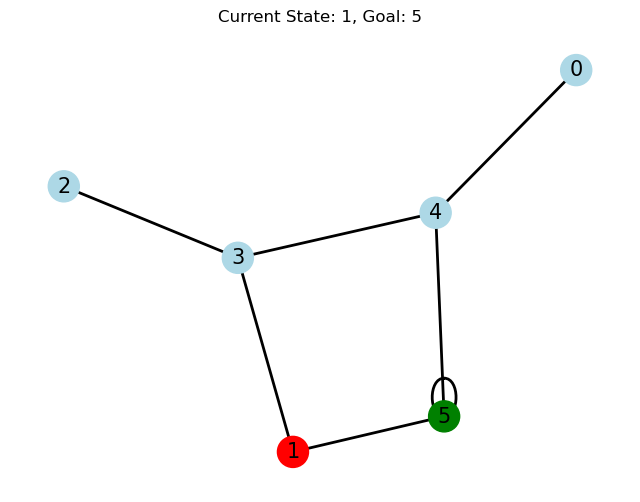

Reached goal in 11 steps!


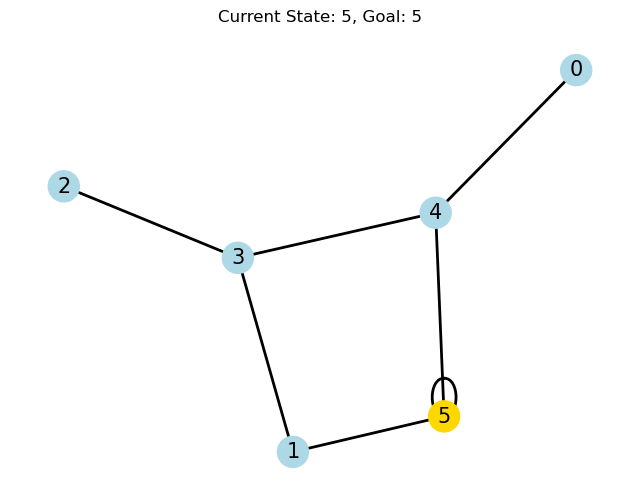

Episode 0
Steps: 11
Total reward: 100.00
Exploration rate: 0.99

Current Q-table:
State 0: [0.]
State 1: [0. 0.]
State 2: [0.]
State 3: [0. 0. 0.]
State 4: [ 0.  0. 10.]
State 5: [0. 0. 0.]

Episode 50: Starting from vertex 0


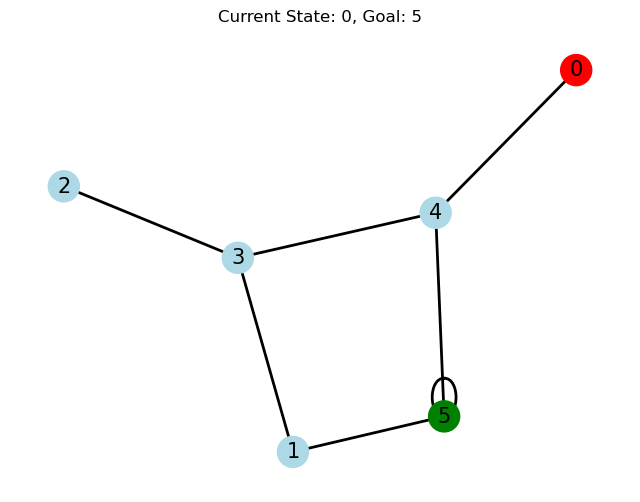

Reached goal in 4 steps!


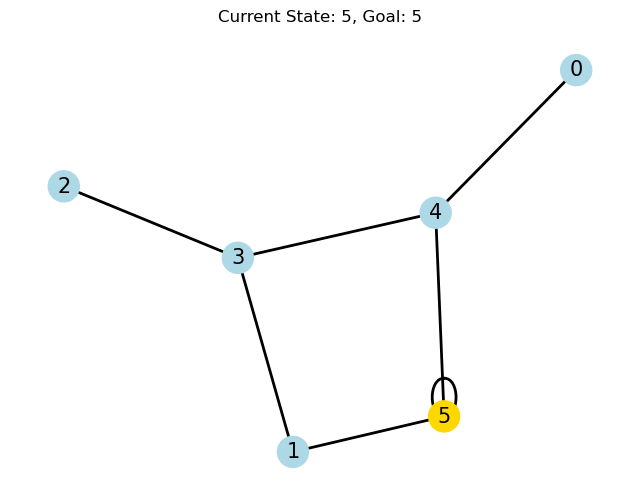

Episode 50
Steps: 4
Total reward: 100.00
Exploration rate: 0.77

Current Q-table:
State 0: [77.78850619]
State 1: [48.31440491 95.2898713 ]
State 2: [56.0351544]
State 3: [79.54436566 26.97057018 71.55804578]
State 4: [53.25106561 55.97006014 90.15229098]
State 5: [0. 0. 0.]

Episode 100: Starting from vertex 2


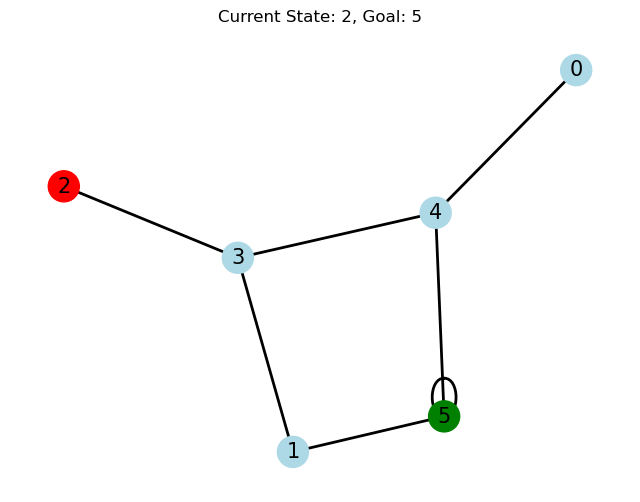

Reached goal in 3 steps!


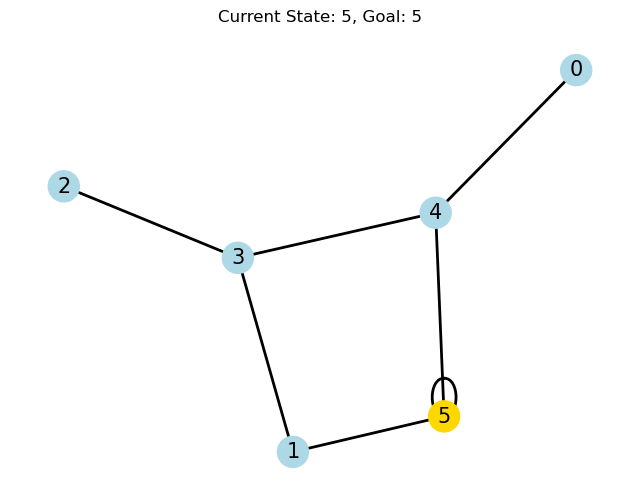

Episode 100
Steps: 3
Total reward: 100.00
Exploration rate: 0.60

Current Q-table:
State 0: [89.8400837]
State 1: [83.52404766 99.69567473]
State 2: [86.10577177]
State 3: [94.09669876 66.80702253 88.33831648]
State 4: [68.12061336 73.55941325 99.21448328]
State 5: [0. 0. 0.]

Episode 150: Starting from vertex 3


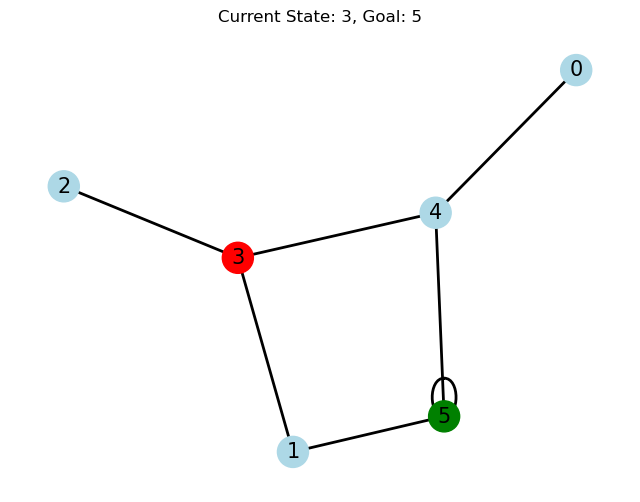

Reached goal in 8 steps!


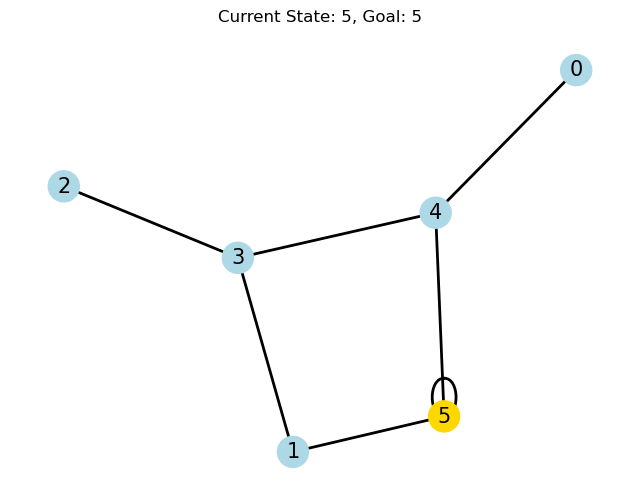

Episode 150
Steps: 8
Total reward: 100.00
Exploration rate: 0.47

Current Q-table:
State 0: [93.31875608]
State 1: [88.52659539 99.98566589]
State 2: [89.26932206]
State 3: [94.94054753 71.58544065 91.72205153]
State 4: [73.16114428 81.21241931 99.91404955]
State 5: [0. 0. 0.]

Episode 200: Starting from vertex 3


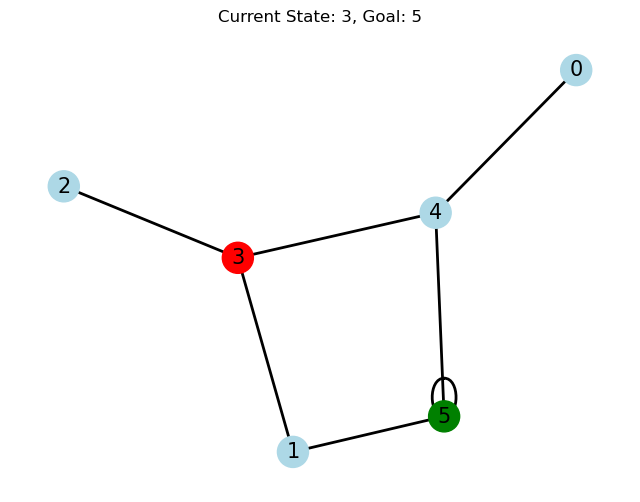

Reached goal in 4 steps!


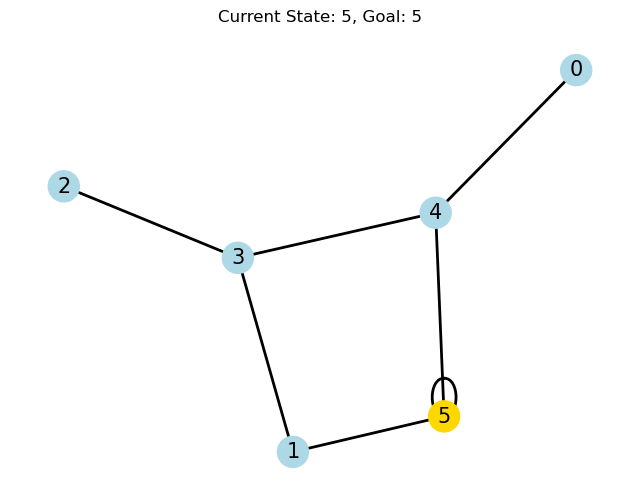

Episode 200
Steps: 4
Total reward: 100.00
Exploration rate: 0.37

Current Q-table:
State 0: [94.63180492]
State 1: [89.63677588 99.99916648]
State 2: [89.92939953]
State 3: [94.99310287 75.30893565 93.05669596]
State 4: [76.21313604 84.31175663 99.99238227]
State 5: [0. 0. 0.]

Episode 250: Starting from vertex 1


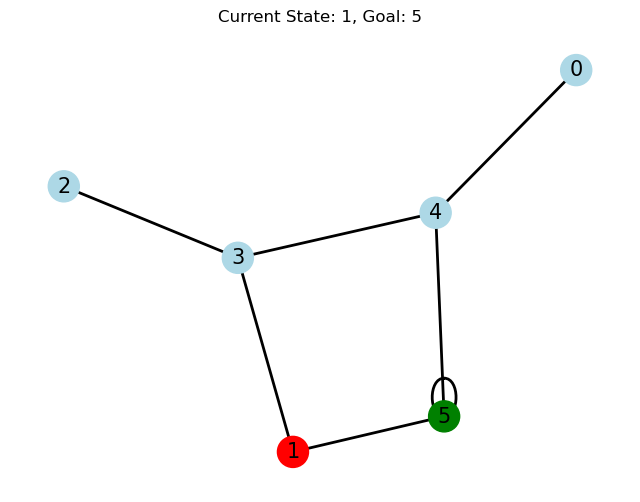

Reached goal in 5 steps!


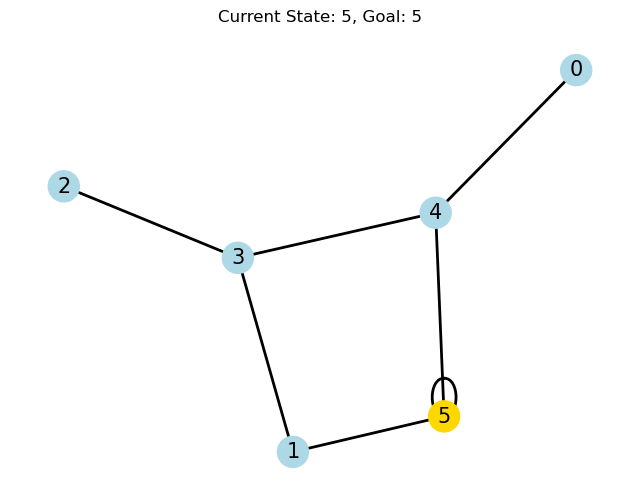

Episode 250
Steps: 5
Total reward: 100.00
Exploration rate: 0.28

Current Q-table:
State 0: [94.93656114]
State 1: [89.88728105 99.99996467]
State 2: [90.20040383]
State 3: [94.99947866 78.10383326 93.5828643 ]
State 4: [82.72413542 85.9205647  99.99907386]
State 5: [0. 0. 0.]


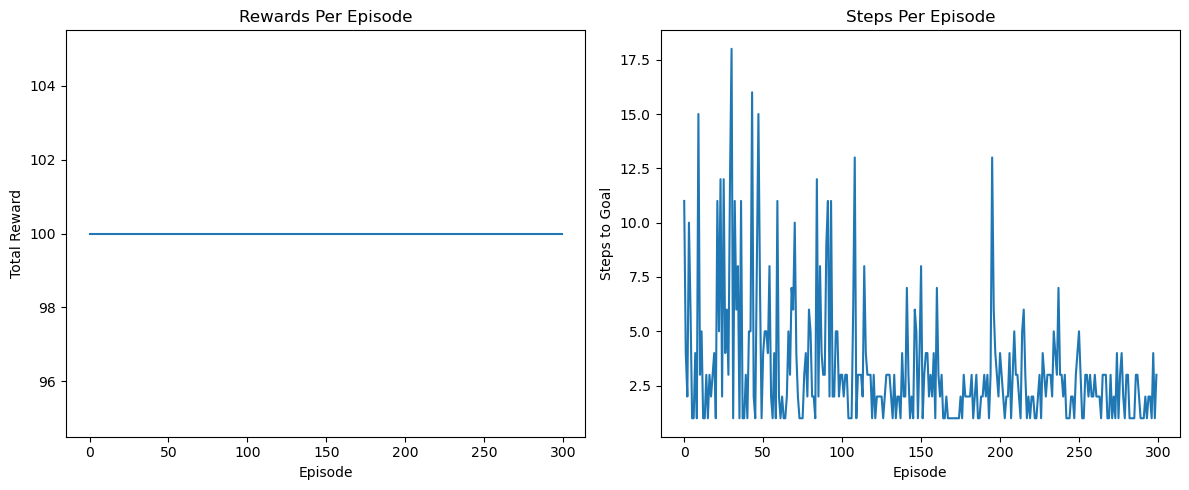


Final Q-table:
State 0: [94.97245026]
State 1: [89.95614885 99.99999891]
State 2: [90.23589481]
State 3: [94.99995349 78.10383326 93.7245472 ]
State 4: [84.75319441 86.3534587  99.99982838]
State 5: [0. 0. 0.]

Learned policy visualization:


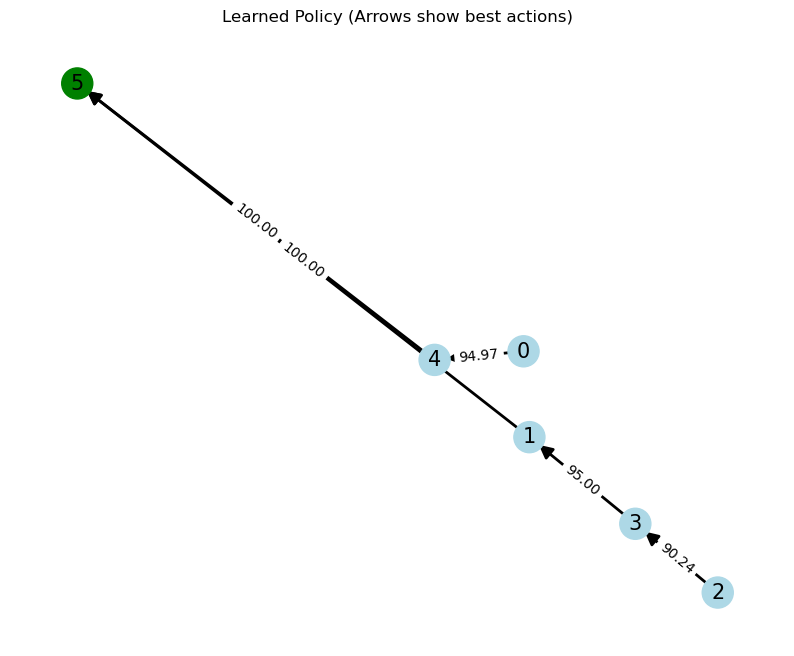


Testing from vertex 0:


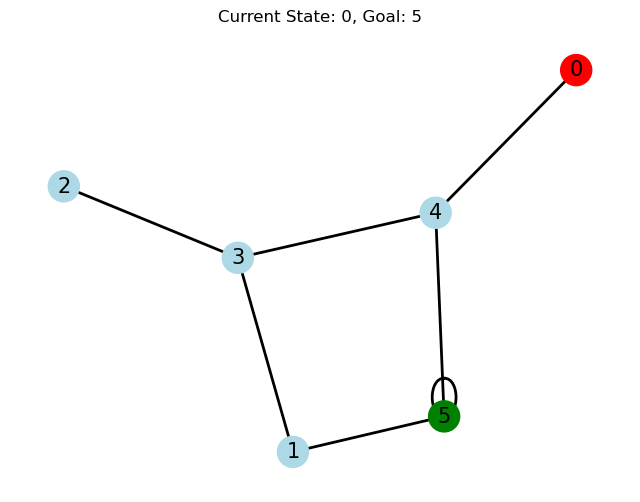

At vertex 0, choosing action 0 with Q-value 94.97


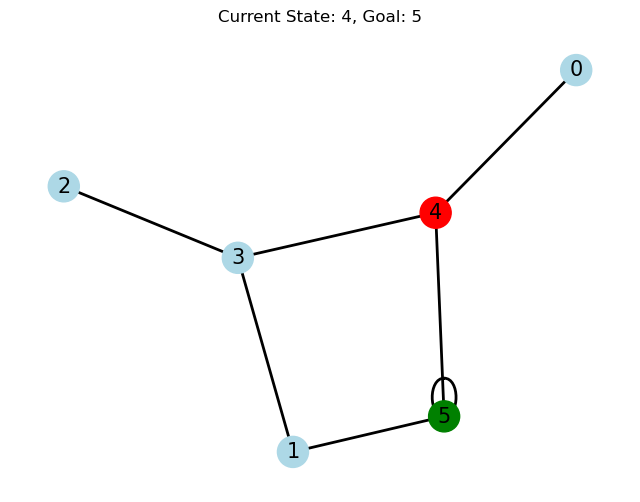

At vertex 4, choosing action 2 with Q-value 100.00


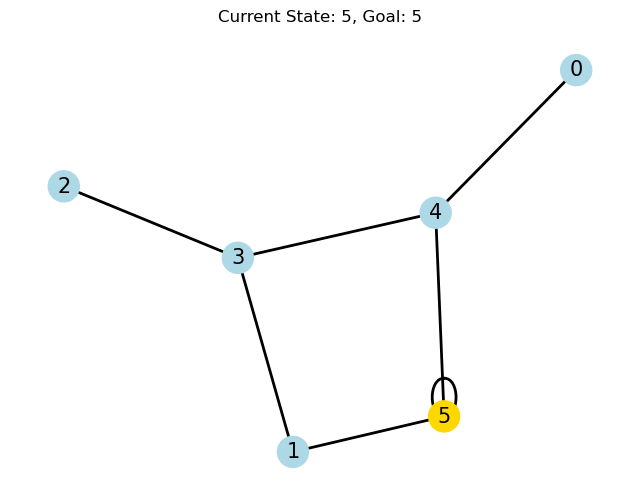

Path taken: 0 -> 4 -> 5
Success! Reached goal in 2 steps.

Testing from vertex 1:


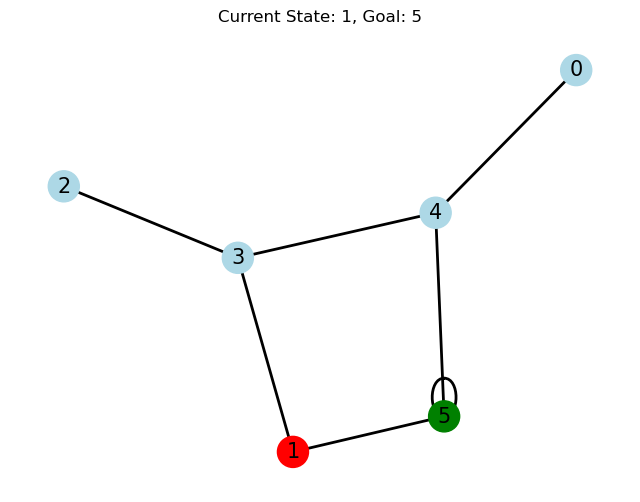

At vertex 1, choosing action 1 with Q-value 100.00


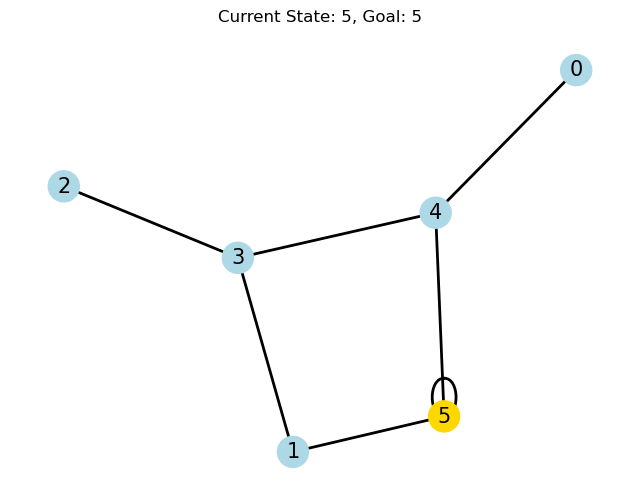

Path taken: 1 -> 5
Success! Reached goal in 1 steps.

Testing from vertex 2:


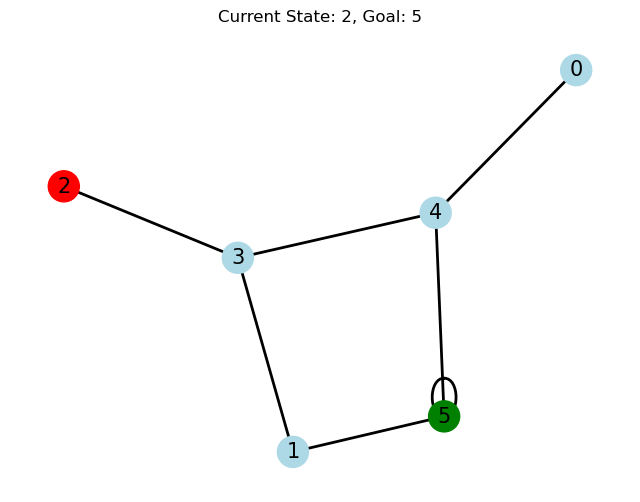

At vertex 2, choosing action 0 with Q-value 90.24


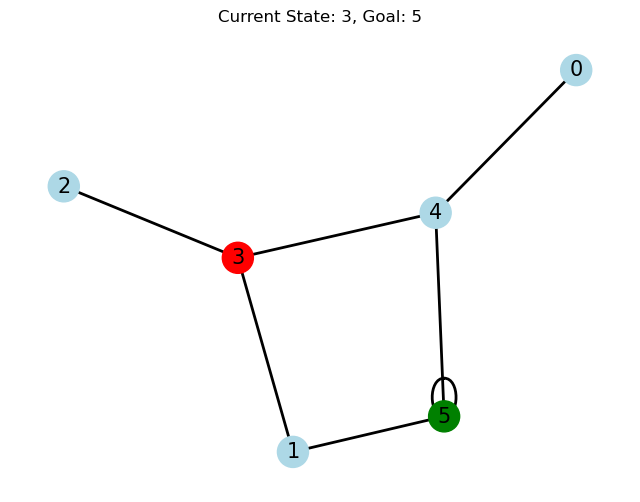

At vertex 3, choosing action 0 with Q-value 95.00


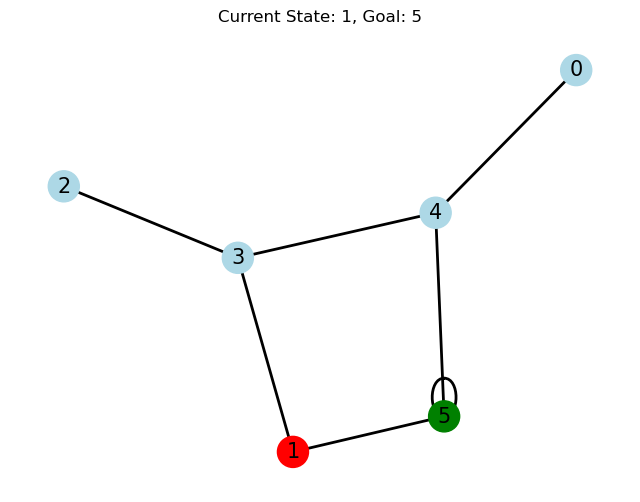

At vertex 1, choosing action 1 with Q-value 100.00


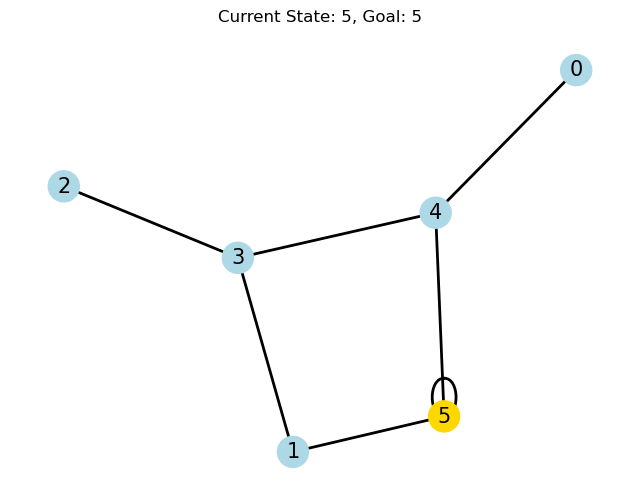

Path taken: 2 -> 3 -> 1 -> 5
Success! Reached goal in 3 steps.

Testing from vertex 3:


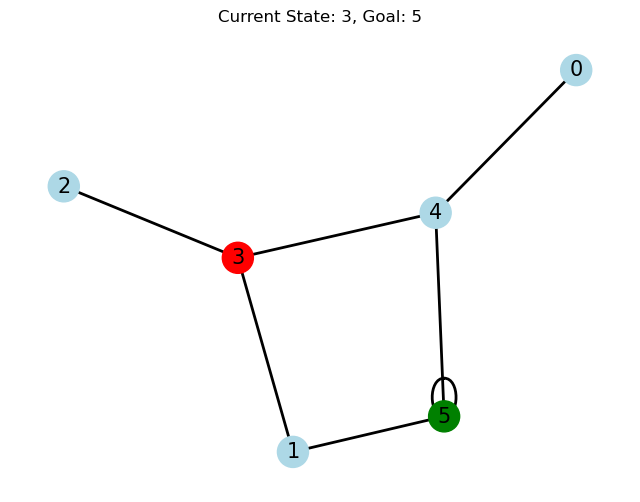

At vertex 3, choosing action 0 with Q-value 95.00


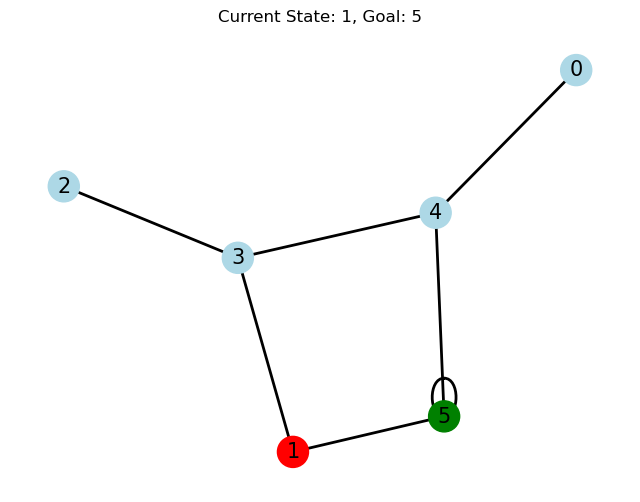

At vertex 1, choosing action 1 with Q-value 100.00


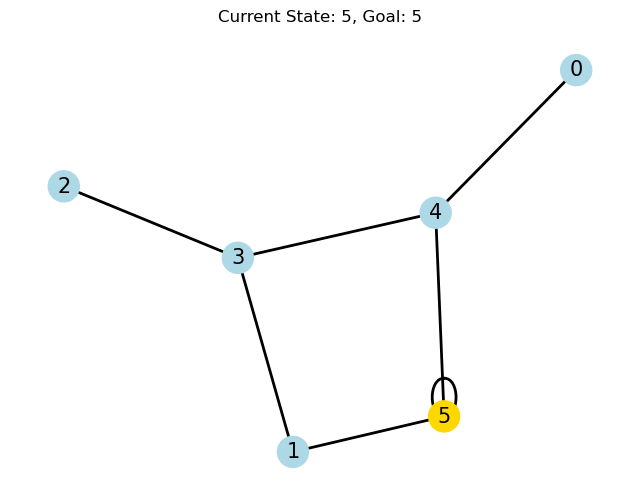

Path taken: 3 -> 1 -> 5
Success! Reached goal in 2 steps.

Testing from vertex 4:


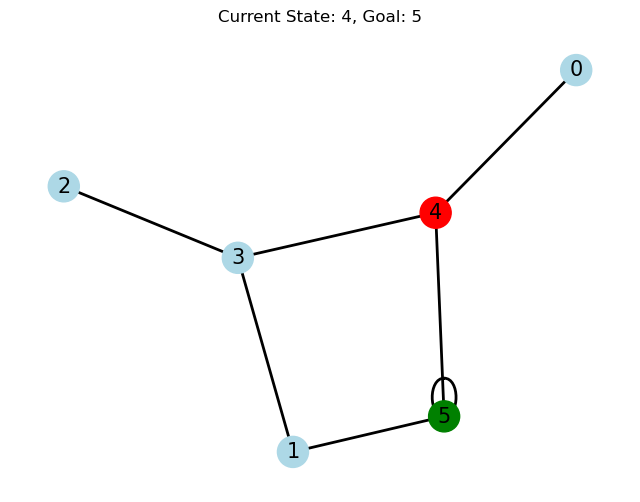

At vertex 4, choosing action 2 with Q-value 100.00


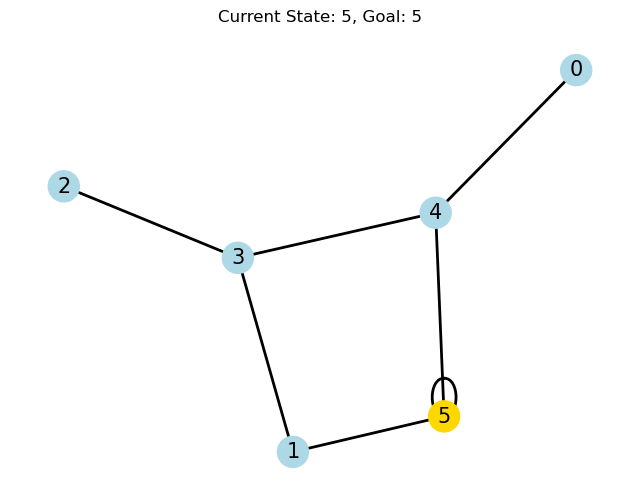

Path taken: 4 -> 5
Success! Reached goal in 1 steps.


In [57]:
# Train the agent
print("Training the agent...")
env, agent = train_agent(episodes=300, render_every=50)

# Show the final Q-table
print("\nFinal Q-table:")
for state in range(6):
    valid_actions = env.get_valid_actions(state)
    print(f"State {state}: {agent.q_table[state, :valid_actions]}")

# Visualize the learned policy
print("\nLearned policy visualization:")
visualize_policy(env, agent)

# Test the policy from each starting position
for start in range(5):  # Test from vertices 0-4
    test_policy(env, agent, start)